In [80]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from itertools import combinations
from src.utils.general_utils import *
import community
import collections

In [81]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actors = pickle.load(file)

In [82]:
def create_actor_network(Actors, min_movies=50):
    # Calculate the number of films for each actor
    Actors["Number_of_films"] = Actors["actor_age_atmovierelease"].apply(len)
    
    # Filter actors with at least `min_movies` films
    actors_with_min_x_movies = Actors[Actors["Number_of_films"] > min_movies]
    
    # Explode the DataFrame to have one row per film per actor
    actors_df = actors_with_min_x_movies.explode('Freebase_movie_ID')
    G = nx.Graph()

    # Group by movie ID and create edges for actors in the same movie
    for movie_id, group in tqdm(actors_df.groupby('Freebase_movie_ID')):
        actor_ids = group['Freebase_actor_ID'].tolist()
        for actor1, actor2 in combinations(actor_ids, 2):
            if actor1 != actor2:
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    # Add attributes to each actor node
    for _, row in actors_df.iterrows():
        actor_id = row['Freebase_actor_ID']
        if actor_id in G:
            G.nodes[actor_id].update({
                'name': row['actor_name'],
                'gender': row.get('actor_gender', None),
                'ethnicity': row.get('ethnicity', None),
                'height': row.get('actor_height', None)
            })
    return G

In [83]:
start_time = time.time()
G = create_actor_network(Actors, min_movies=20)
print("Created graph with actors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()
print("time to compute :", end_time - start_time, "seconds")

100%|█████████████████████████████████████████████████████████████████████████| 44122/44122 [00:02<00:00, 21816.74it/s]


Created graph with actors:
Number of nodes: 3637
Number of edges: 206863
time to compute : 9.522464036941528 seconds


In [84]:
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter=collections.Counter(values)
print(counter)
community_sizes = collections.Counter(partition.values())

Counter({1: 1583, 0: 1169, 7: 356, 6: 311, 3: 88, 2: 87, 4: 23, 8: 11, 5: 4, 9: 3, 10: 2})


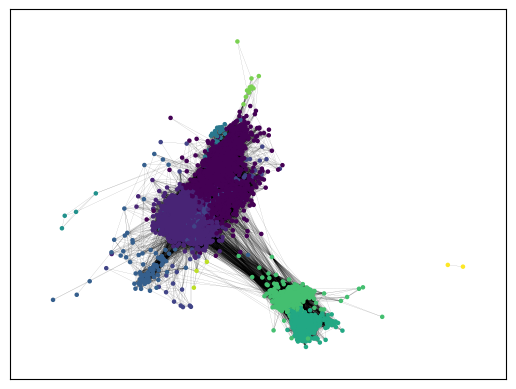

time to compute : 45.63962507247925 seconds


In [86]:
start_time = time.time()
sp = nx.spring_layout(G, k=0.1, seed=42)
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=5, node_color=values, width=0.05)
# plt.axes('off')
plt.show()
end_time = time.time()
print("time to compute :", end_time - start_time, "seconds")

In [88]:
partition = pd.Series(partition)
partition.name = "cluster_id"
actors_clustered = pd.merge(Actors,partition, right_index=True, left_on= "Freebase_actor_ID")

In [89]:
actors_clustered.shape

(3637, 10)

In [90]:
actors_clustered.cluster_id.value_counts()

cluster_id
1     1583
0     1169
7      356
6      311
3       88
2       87
4       23
8       11
5        4
9        3
10       2
Name: count, dtype: int64

In [91]:
index_to_keep = partition.value_counts()[partition.value_counts()>10].index
index_to_keep

Index([1, 0, 7, 6, 3, 2, 4, 8], dtype='int64', name='cluster_id')

In [92]:
example = actors_clustered[actors_clustered["cluster_id"]==8]

C:\Users\emile\AppData\Local\Temp\ipykernel_9352\214506570.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_counts = example_counts[abc_counts.Count>5]


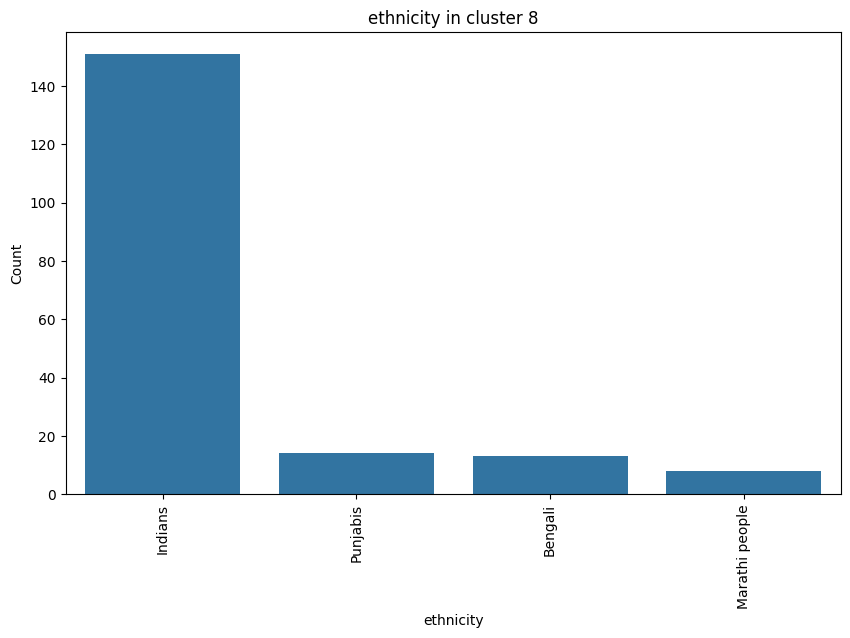

In [94]:
example_counts = pd.DataFrame(example, columns=['ethnicity']).value_counts().reset_index()
example_counts.columns = ['ethnicity', 'Count']

example_counts = example_counts[abc_counts.Count>5]

plt.figure(figsize=(10, 6))
sns.barplot(data=abc_counts, x='ethnicity', y = 'Count')
plt.xticks(rotation=90)  
plt.title('ethnicity in cluster 8')
plt.show()

Her per exemple we see that cluster 8 is composed of indian people. We will do other analysis with theses clusters to see what is determining them. Is it the gender of the actors ? The country they're from or the kind of career

In [76]:
print(type(partition))


<class 'pandas.core.series.Series'>
